In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
# Veriyi yükleme
df = pd.read_csv('age_gender.csv')

# Örneğin nasıl göründüğüne bakalım
print(df.head())

   age  ethnicity  gender                        img_name   
0    1          2       0  20161219203650636.jpg.chip.jpg  \
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...  


In [55]:
print(df.shape)
df.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [56]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

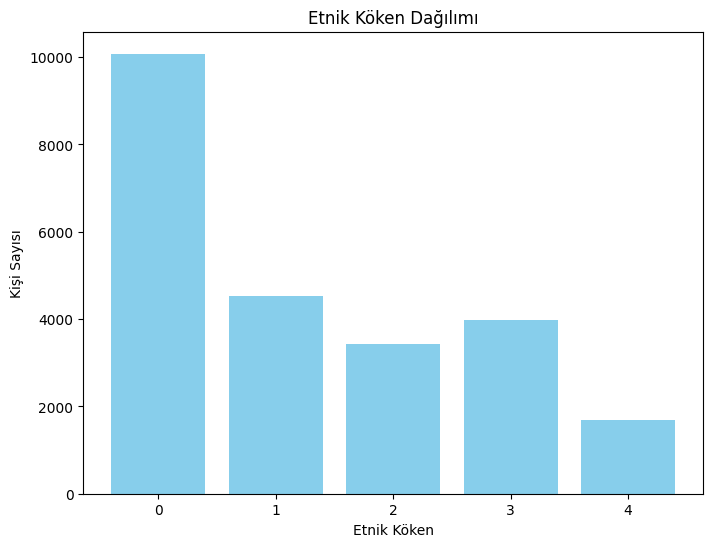

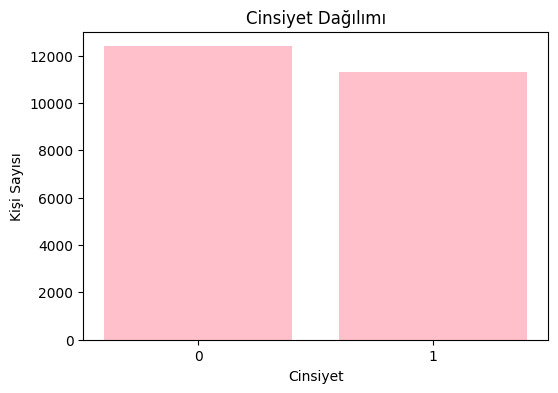

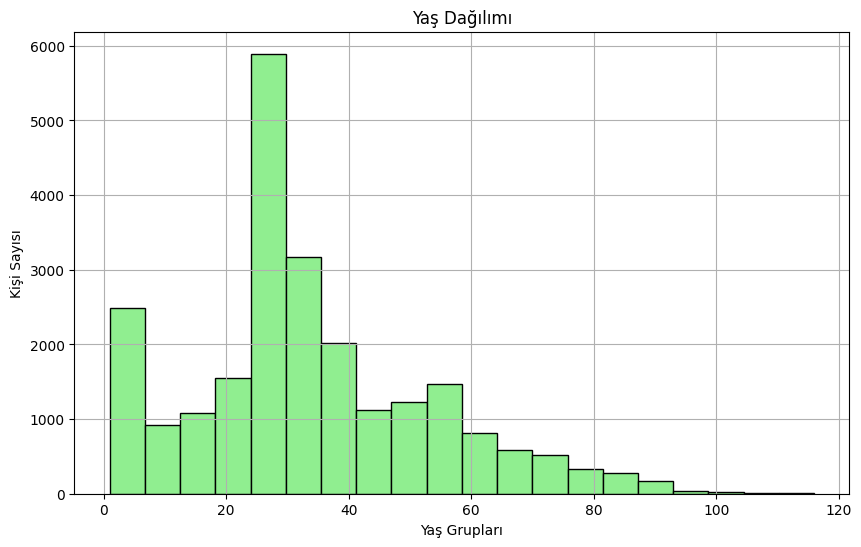

In [57]:
import matplotlib.pyplot as plt

# Etnik köken (ethnicity) sayımları
ethnicity_counts = df['ethnicity'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Etnik Köken')
plt.ylabel('Kişi Sayısı')
plt.title('Etnik Köken Dağılımı')
plt.xticks(np.arange(5), ['0', '1', '2', '3', '4'])
plt.show()

# Cinsiyet (gender) sayımları
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(gender_counts.index, gender_counts.values, color='pink')
plt.xlabel('Cinsiyet')
plt.ylabel('Kişi Sayısı')
plt.title('Cinsiyet Dağılımı')
plt.xticks(np.arange(2), ['0', '1'])
plt.show()

# Yaş (age) grupları sayımları için örnek (genişletilebilir)
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Yaş Grupları')
plt.ylabel('Kişi Sayısı')
plt.title('Yaş Dağılımı')
plt.grid(True)
plt.show()


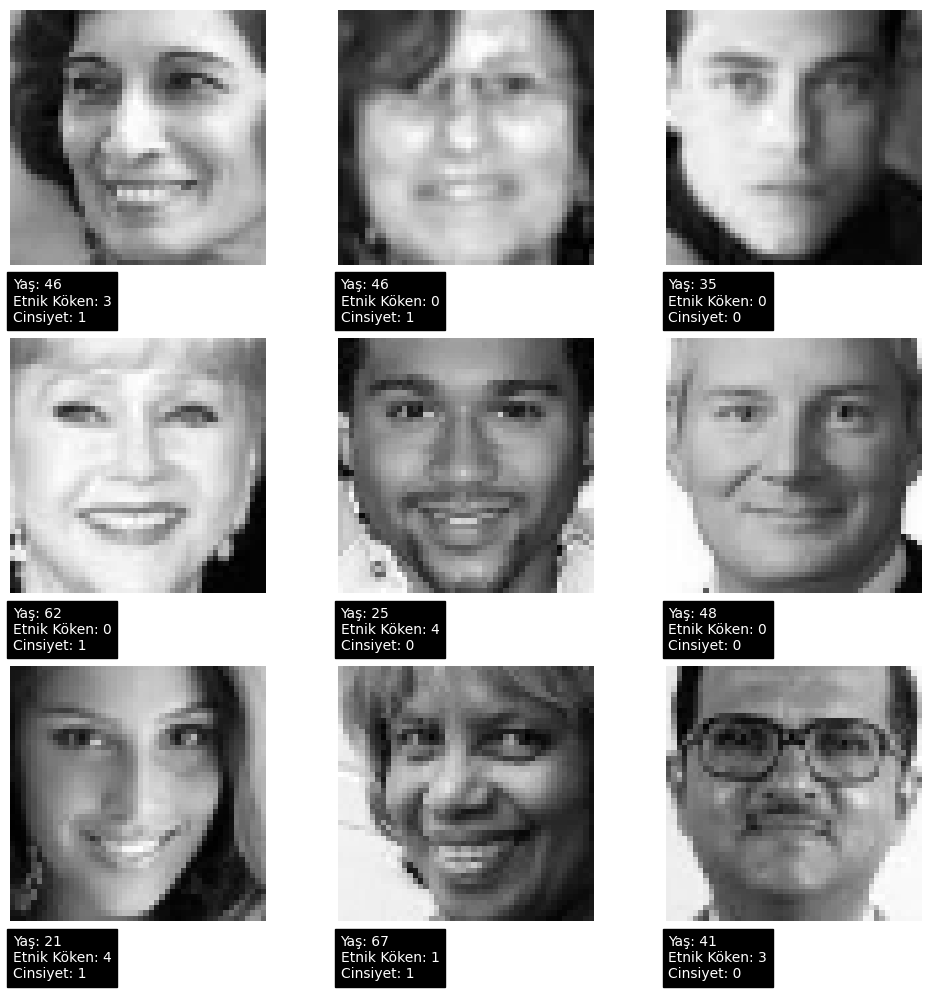

In [58]:
df_sample = df.sample(9)

# 3x3'lük bir subplot oluşturalım
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, (index, row) in enumerate(df_sample.iterrows()):
    # Pikselleri 48x48 boyutunda yeniden şekillendirme
    pixels = np.array(row['pixels'].split(), dtype='uint8')
    image = pixels.reshape((48, 48))
    
    # Resmi gösterme
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title("")  # Başlık kısmını boşaltma
    
    # Alt kısma bilgileri yazma
    info_str = f"Yaş: {row['age']}\nEtnik Köken: {row['ethnicity']}\nCinsiyet: {row['gender']}"
    axes[i].text(0, 50, info_str, fontsize=10, color='white', backgroundcolor='black', ha='left', va='top')
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [59]:
# Piksel değerlerini numpy array'e dönüştürme fonksiyonu
def process_pixels(pixel_sequence):
    pixels = [int(p) for p in pixel_sequence.split()]
    return np.array(pixels).reshape(48, 48, 1)  # 48x48x1 boyutunda bir tensör döndürülüyor


# Piksel değerlerini işleme
X = np.stack(df['pixels'].apply(process_pixels))

# Yaşları 5 farklı gruba ayırma
bins = [0, 18, 30, 50, 70, np.inf]
labels = [0, 1, 2, 3, 4]  # 5 farklı yaş grubu
y_age = df['age'].values
y_age_categorical = pd.cut(y_age, bins=bins, labels=labels)
y_age_categorical = to_categorical(y_age_categorical, num_classes=len(labels))
y_gender = df['gender'].values
y_ethnicity = df['ethnicity'].values

y_ethnicity = to_categorical(y_ethnicity, num_classes=max(y_ethnicity)+1)



# Veriyi train/test olarak ayırma
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_ethnicity_train, y_ethnicity_test = train_test_split(
    X, y_age_categorical, y_gender, y_ethnicity, test_size=0.2, random_state=42)



# Normalizasyon
X_train = X_train / 255.0
X_test = X_test / 255.0


In [60]:
model_age = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # Yaş tahmini için softmax aktivasyon
])

model_age.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_age.summary()

# Eğitme
history_age = model_age.fit(X_train, y_age_train, epochs=20, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 4, 4, 128)       

In [61]:
model_gender = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Cinsiyet tahmini binary classification
])

model_gender.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_gender.summary()

# Eğitme
history_gender = model_gender.fit(X_train, y_gender_train, epochs=20, validation_split=0.2)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 4, 4, 128)       

In [62]:
model_ethnicity = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Etnik köken tahmini çok sınıflı bir sınıflandırma problemi
])

model_ethnicity.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_ethnicity.summary()

# Eğitme
history_ethnicity = model_ethnicity.fit(X_train, y_ethnicity_train, epochs=20, validation_split=0.2)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 4, 4, 128)      

In [63]:
# Yaş tahmini değerlendirme
loss_age, mae_age = model_age.evaluate(X_test, y_age_test)
print(f'Yaş tahmini - Kayıp: {loss_age}, Ortalama Mutlak Hata: {mae_age}')

# Cinsiyet tahmini değerlendirme
loss_gender, accuracy_gender = model_gender.evaluate(X_test, y_gender_test)
print(f'Cinsiyet tahmini - Kayıp: {loss_gender}, Doğruluk: {accuracy_gender}')

# Etnik köken tahmini değerlendirme
loss_ethnicity, accuracy_ethnicity = model_ethnicity.evaluate(X_test, y_ethnicity_test)
print(f'Etnik köken tahmini - Kayıp: {loss_ethnicity}, Doğruluk: {accuracy_ethnicity}')


149/149 [==============================] - 2s 14ms/step - loss: 0.9146 - accuracy: 0.6650
Yaş tahmini - Kayıp: 0.9145640730857849, Ortalama Mutlak Hata: 0.6650495529174805
149/149 [==============================] - 2s 13ms/step - loss: 0.4159 - accuracy: 0.8804
Cinsiyet tahmini - Kayıp: 0.4159057140350342, Doğruluk: 0.8804049491882324
149/149 [==============================] - 2s 13ms/step - loss: 0.7867 - accuracy: 0.7695
Etnik köken tahmini - Kayıp: 0.786692202091217, Doğruluk: 0.7694579362869263


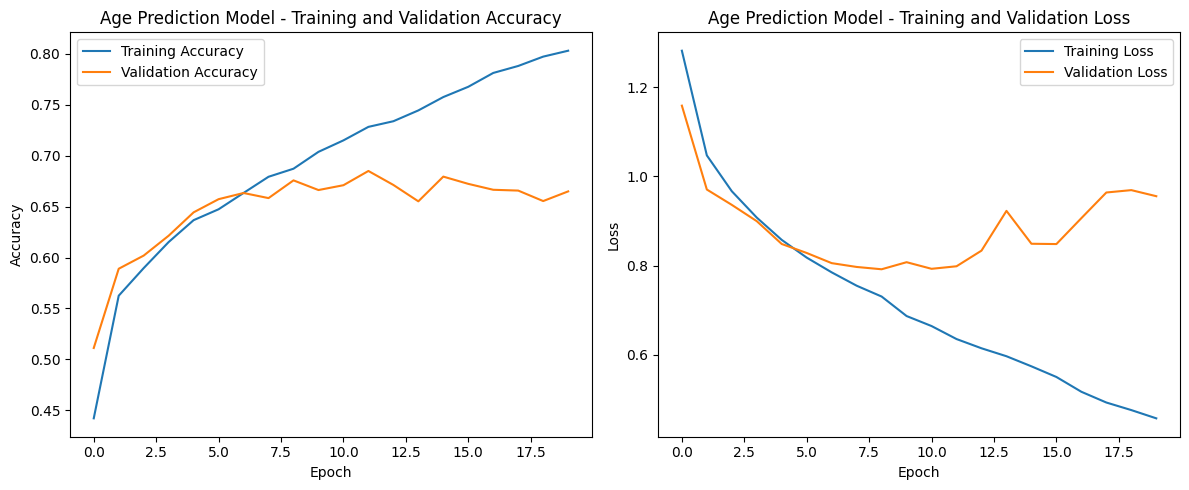

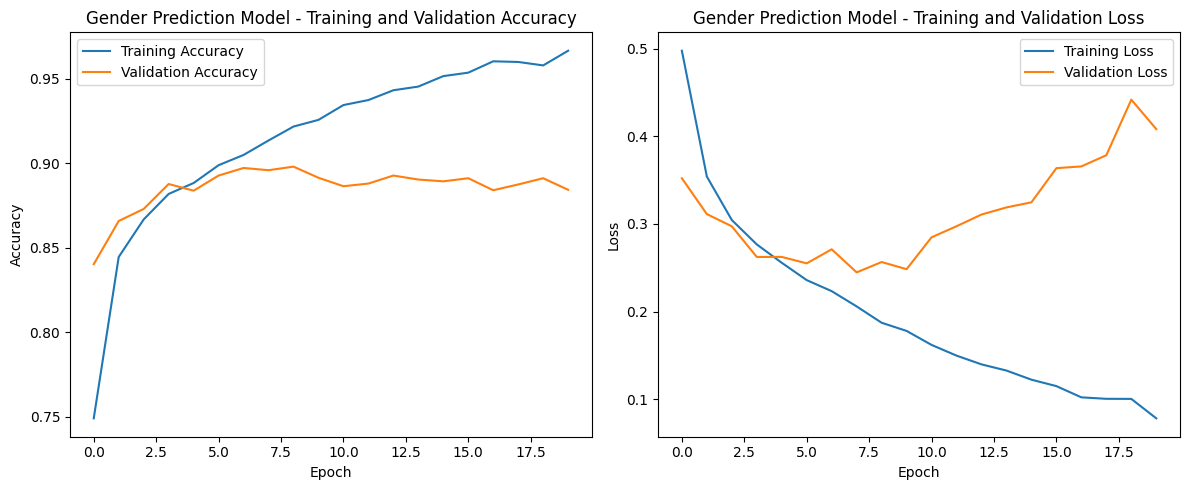

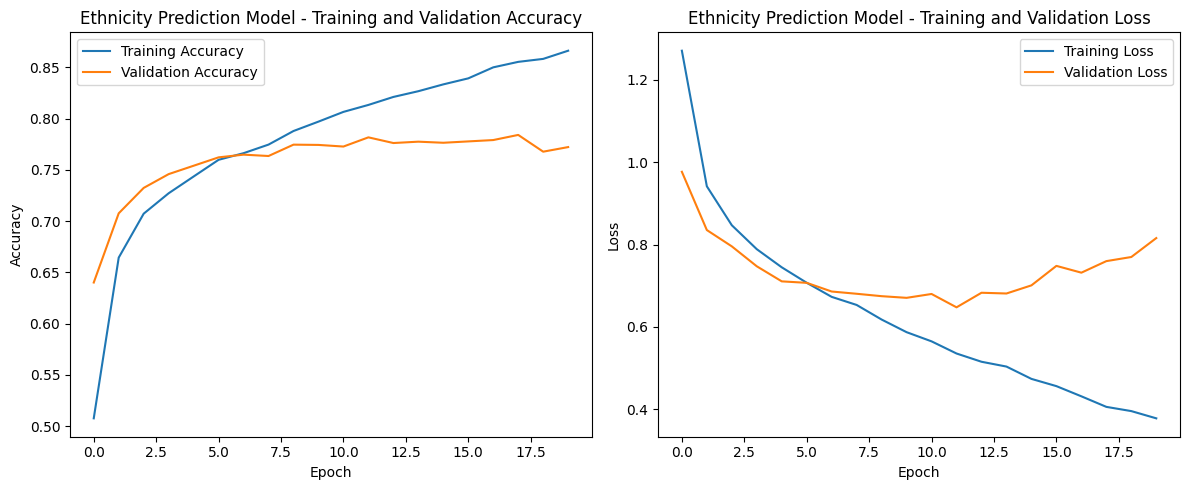

In [65]:
# Yaş tahmini için doğruluk ve kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_age.history['accuracy'], label='Training Accuracy')
plt.plot(history_age.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Age Prediction Model - Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_age.history['loss'], label='Training Loss')
plt.plot(history_age.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Age Prediction Model - Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Cinsiyet tahmini için doğruluk ve kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_gender.history['accuracy'], label='Training Accuracy')
plt.plot(history_gender.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Gender Prediction Model - Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gender.history['loss'], label='Training Loss')
plt.plot(history_gender.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gender Prediction Model - Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Etnik köken tahmini için doğruluk ve kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ethnicity.history['accuracy'], label='Training Accuracy')
plt.plot(history_ethnicity.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Ethnicity Prediction Model - Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ethnicity.history['loss'], label='Training Loss')
plt.plot(history_ethnicity.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ethnicity Prediction Model - Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
